P.S.: the "vmax" in MI plots are set up for visual purposes; check its statistics for accurate info

path: 

/xdisk/chanc/share/

there are two folders: GRMHD_dt500M and GRMHD_dt5M

under GRMHD_dt500M: Ma+0.5_w5  Ma+0.94_w5  Ma-0.5_w5  Ma-0.94_w5  Ma0_w5  Sa+0.5_w5  Sa+0.94_w5  Sa-0.5_w5  Sa-0.94_w5  Sa0_w5

under GRMHD_dt5M: Ma+0.94_w5  Ma-0.94_w5  Sa+0.94_w5, 5000 - 5999

In [1]:
import warnings

from toolz import valmap

import h5py
import pyharm

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pyharm.plots import plot_dumps as pplt

In [2]:
pyharm.units.get_cgs()

{'CL': 29979245800.0,
 'QE': 4.8032068e-10,
 'EE': 4.8032068e-10,
 'ME': 9.1093826e-28,
 'MP': 1.67262171e-24,
 'MN': 1.67492728e-24,
 'HPL': 6.6260693e-27,
 'HBAR': 1.0545717e-27,
 'KBOL': 1.3806505e-16,
 'GNEWT': 6.6742e-08,
 'SIG': 5.6704e-05,
 'AR': 7.5657e-15,
 'THOMSON': 6.65245873e-25,
 'JY': 1e-23,
 'PC': 3.085678e+18,
 'AU': 14959787069100.0,
 'MSOLAR': 1.989e+33,
 'RSOLAR': 69600000000.0,
 'LSOLAR': 3.827e+33}

In [3]:
# dt=200M
i0 = 5010 # initial  frame
i1 = 5051 # 1 + last frame

fmt = 'torus.out0.{:05d}.h5'

qualities = ['RHO', 'Pg', 'bsq', 'beta', 'Theta', 'Thetae']

In [4]:
def fname(i, src): # closure on `src` and `fmt`
    return (src+fmt).format(i)

In [5]:
# some constants
cl = 29979245800.0 # speed of light in cgs
mp = 1.67262171e-24
kb = 1.3806505e-16

In [6]:
# R
def R(dump, Rh, Rl):
    # with warnings.catch_warnings(record=True) as w:
    '''
    try: 
        beta = dump['beta']
    except RuntimeWarning as warning:
        if str(warning) == "divide by zero encountered in true_divide":
            beta = np.zeros(dump['Pg'])
    '''
    beta = dump['beta']
    return Rl/(1+beta**2)+Rh*beta**2/(1+beta**2)

In [7]:
# electron temperature
def Te(dump, Rh, Rl=1, gamma=4/3):
    if gamma == 4/3:
        y = 1
        z = 3
        gamma_i = 4/3
        gamma_e = 7/3
    if gamma == 13/9:
        y = 1
        z = 2
        gamma_i = 13/9
        gamma_e = 133/36
    if gamma == 5/3:
        y = 1
        z = 1
        gamma_i = 5/3
        gamma_e = 5/3
    beta = dump['beta']
    u = dump['Pg']/(gamma-1)
    r = R(dump, Rh, Rl)
    numerator = mp*cl**2*u*(gamma_e-1)*(gamma_i-1)
    denom = kb*dump['RHO']*(y*(gamma_i-1)+r*z*(gamma_e-1))

    electron_T = numerator/ denom
    dump.cache['Te'] = electron_T
    return electron_T

In [8]:
src_ma_5M = '/xdisk/chanc/proj/eht/GRMHD_dt5M/Ma+0.94_w5/'
src_sa_5M = '/xdisk/chanc/proj/eht/GRMHD_dt5M/Sa+0.94_w5/'

src_ma_500M = '/xdisk/chanc/proj/eht/GRMHD_dt500M/Ma+0.94_w5/'
src_sa_500M = '/xdisk/chanc/proj/eht/GRMHD_dt500M/Sa+0.94_w5/'

In [9]:
def calculate_average(i0, i1, src, quantity):
    avg = 0.
    for i in range(i0, i1):
        dump = pyharm.load_dump(fname(i, src))
        quant = dump[quantity]
        avg += quant
        del dump
    avg /= i1-i0
    return avg

In [10]:
def calculate_variance(i0, i1, src, quantity, avg):
    var = 0.
    for i in range(i0, i1):
        dump = pyharm.load_dump(fname(i, src))
        quant = dump[quantity]
        var += (quant - avg)**2
        del dump
    var /= i1-i0
    return var

In [11]:
def calculate_avgTe(i0, i1, src, Rh):
    avg_Te = 0.
    for i in range(i0, i1):
        dump = pyharm.load_dump(fname(i, src))
        avg_Te += Te(dump, Rh)
        del dump
    avg_Te /= i1-i0
    return avg_Te

In [12]:
def calculate_varTe(i0, i1, src, Rh, avg):
    var_Te = 0.
    for i in range(i0, i1):
        dump = pyharm.load_dump(fname(i, src))
        var_Te += (Te(dump, Rh) - avg)**2
        del dump
    var_Te /= i1-i0
    return var_Te

In [13]:
def MI(dump, quantity='Te'):
    avg = 'avg' + quantity
    var = 'var' + quantity
    std = dump.cache[var]**0.5
    dump.cache['MI('+ quantity +')'] = std/dump.cache[avg]

In [14]:
def get_statistics(dump, quantity):
    """
    dumps: the dumps' dictionary in the format of dumps={'5010':arr1, '5011':arr2, etc}
    quantity: string, the quality whose statistics we want 
    """
    print('statistics on ' + quantity + ':')
    print('max ' + quantity + ':')
    maximum = np.max(dump.cache[quantity])
    print("{:e}".format(maximum))
    print('percentile on ' + quantity+ ' [25%, 75%, 90%]:')
    # percentile of the flattened grid
    percentile = np.percentile(dump.cache[quantity], [25, 75, 90])
    print(percentile)

# $\gamma = \frac{4}{3}$, $\beta$, Te, Pg, $\rho$, and bsq: $\sigma$ and MI

MAD, Pg, $\rho$, bsq

In [54]:
avg_Pg = calculate_average(i0, i1, src_ma_5M, 'Pg')

In [55]:
var_Pg = calculate_variance(i0, i1, src_ma_5M, 'Pg', avg_Pg)

In [19]:
dump0 = pyharm.load_dump(fname(i0, src_ma_5M))

In [57]:
dump0.cache['avgPg'] = avg_Pg
dump0.cache['varPg'] = var_Pg

In [58]:
get_statistics(dump0, 'avgPg')
print()
get_statistics(dump0, 'varPg')

statistics on avgPg:
max avgPg:
4.984904e+00
percentile on avgPg [25%, 75%, 90%]:
[4.18268965e-06 1.78635592e-03 2.01206909e-02]

statistics on varPg:
max varPg:
1.379957e+01
percentile on varPg [25%, 75%, 90%]:
[2.92105080e-13 5.68285937e-07 1.99489762e-04]


In [59]:
MI(dump0, 'Pg')
get_statistics(dump0, 'MI(Pg)')

statistics on MI(Pg):
max MI(Pg):
5.172663e+00
percentile on MI(Pg) [25%, 75%, 90%]:
[0.07925533 0.57933588 1.15565654]


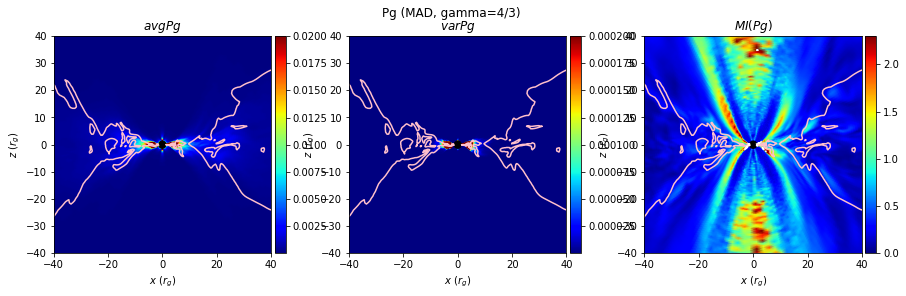

In [60]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dump0, 'avgPg', window=w, vmin=10**(-6), vmax=2.*10**(-2))
pplt.plot_xz(axes[1], dump0, 'varPg', window=w, vmin=10**(-13), vmax=2.*10**(-4))
pplt.plot_xz(axes[2], dump0, 'MI(Pg)', window=w, vmin=0., vmax=2.3)
pplt.overlay_contours(axes[0], dump0, 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dump0, 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dump0, 'beta',(1.0,), color='pink')
# 3 σ away, i.e. MI > 3
pplt.overlay_contours(axes[2], dump0, 'MI(Pg)',(3.0, ), color='white')
plt.suptitle('Pg (MAD, gamma=4/3)')
plt.show()

In [61]:
avg_RHO = calculate_average(i0, i1, src_ma_5M, 'RHO')

In [62]:
var_RHO = calculate_variance(i0, i1, src_ma_5M, 'RHO', avg_RHO)

In [63]:
dump0.cache['avgRHO'] = avg_RHO
dump0.cache['varRHO'] = var_RHO

In [64]:
get_statistics(dump0, 'avgRHO')
print()
get_statistics(dump0, 'varRHO')

statistics on avgRHO:
max avgRHO:
1.249371e+01
percentile on avgRHO [25%, 75%, 90%]:
[0.00061741 0.09674633 0.35025561]

statistics on varRHO:
max varRHO:
1.577499e+02
percentile on varRHO [25%, 75%, 90%]:
[1.62159180e-09 7.13746062e-04 8.56374238e-02]


In [65]:
MI(dump0, 'RHO')
get_statistics(dump0, 'MI(RHO)')

statistics on MI(RHO):
max MI(RHO):
5.655855e+00
percentile on MI(RHO) [25%, 75%, 90%]:
[0.0548123  0.51947968 1.22072339]


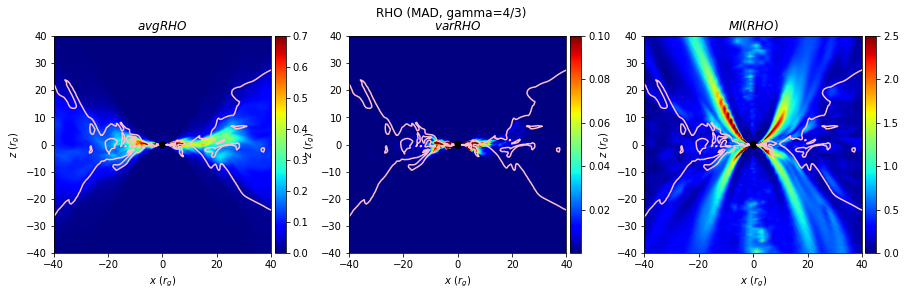

In [66]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dump0, 'avgRHO', window=w, vmin=0., vmax=0.7)
pplt.plot_xz(axes[1], dump0, 'varRHO', window=w, vmin=10**(-9), vmax=10**(-1))
pplt.plot_xz(axes[2], dump0, 'MI(RHO)', window=w, vmin=0., vmax=2.5)
pplt.overlay_contours(axes[0], dump0, 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dump0, 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dump0, 'beta',(1.0,), color='pink')
# 3 σ away, i.e. MI > 3
# pplt.overlay_contours(axes[2], dump0, 'MI(RHO)',(3.0, ), color='white')
plt.suptitle('RHO (MAD, gamma=4/3)')
plt.show()

In [16]:
avg_bsq = calculate_average(i0, i1, src_ma_5M, 'bsq')

In [17]:
var_bsq = calculate_variance(i0, i1, src_ma_5M, 'bsq', avg_bsq)

In [20]:
dump0.cache['avgbsq'] = avg_bsq
dump0.cache['varbsq'] = var_bsq

In [21]:
get_statistics(dump0, 'avgbsq')
print()
get_statistics(dump0, 'varbsq')

statistics on avgbsq:
max avgbsq:
3.121569e+01
percentile on avgbsq [25%, 75%, 90%]:
[2.98116618e-06 5.07612977e-02 1.64162192e+00]

statistics on varbsq:
max varbsq:
6.179953e+01
percentile on varbsq [25%, 75%, 90%]:
[2.60320661e-13 6.97967578e-05 3.86021385e-02]


In [22]:
MI(dump0, 'bsq')
get_statistics(dump0, 'MI(bsq)')

statistics on MI(bsq):
max MI(bsq):
2.696440e+00
percentile on MI(bsq) [25%, 75%, 90%]:
[0.06891633 0.40771213 0.66896539]


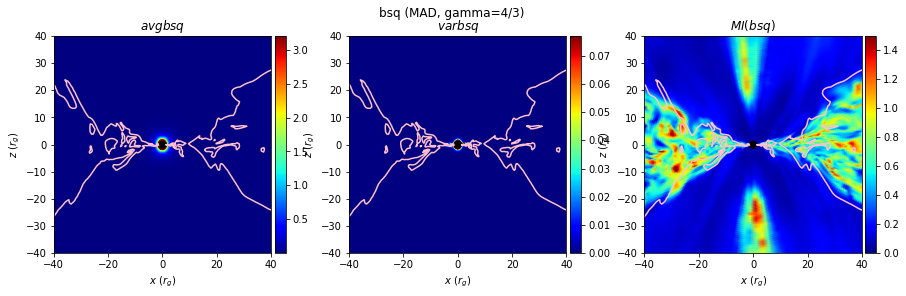

In [23]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dump0, 'avgbsq', window=w, vmin=10**(-6), vmax=3.2)
pplt.plot_xz(axes[1], dump0, 'varbsq', window=w, vmin=10**(-13), vmax=7.7*10**(-2))
pplt.plot_xz(axes[2], dump0, 'MI(bsq)', window=w, vmin=0., vmax=1.5)
pplt.overlay_contours(axes[0], dump0, 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dump0, 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dump0, 'beta',(1.0,), color='pink')
# 3 σ away, i.e. MI > 3
# pplt.overlay_contours(axes[2], dump0, 'MI(bsq)',(3.0, ), color='white')
plt.suptitle('bsq (MAD, gamma=4/3)')
plt.show()

MAD model, $R_{high} = 1$

In [18]:
avg_Te = calculate_avgTe(i0, i1, src_ma_5M, 1.)

In [19]:
var_Te = calculate_varTe(i0, i1, src_ma_5M, 1., avg_Te)

In [20]:
dump0 = pyharm.load_dump(fname(i0, src_ma_5M))

In [21]:
dump0.cache['avgTe'] = avg_Te
dump0.cache['varTe'] = var_Te

In [24]:
get_statistics(dump0, 'avgTe')
print()
get_statistics(dump0, 'varTe')

statistics on avgTe:
max avgTe:
3.992990e+12
percentile on avgTe [25%, 75%, 90%]:
[9.39473314e+09 2.76168116e+11 5.22596672e+11]

statistics on varTe:
max varTe:
1.188983e+25
percentile on varTe [25%, 75%, 90%]:
[1.38530551e+17 9.98166726e+21 3.90330603e+22]


In [27]:
MI(dump0, 'Te')
get_statistics(dump0, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
3.703199e+00
percentile on MI(Te) [25%, 75%, 90%]:
[0.03706794 0.38871943 0.64524071]


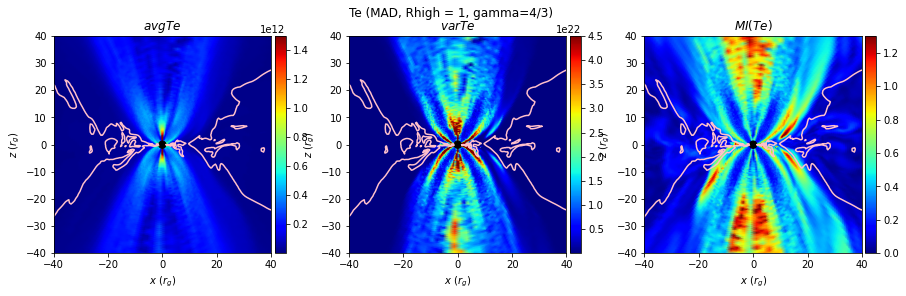

In [45]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dump0, 'avgTe', window=w, vmin=10**7, vmax=1.5*10**12)
pplt.plot_xz(axes[1], dump0, 'varTe', window=w, vmin=10**17, vmax=4.5*10**22)
pplt.plot_xz(axes[2], dump0, 'MI(Te)', window=w, vmin=0., vmax=1.3)
pplt.overlay_contours(axes[0], dump0, 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dump0, 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dump0, 'beta',(1.0,), color='pink')
# 3 σ away, i.e. MI > 3
# pplt.overlay_contours(axes[2], dump0, 'MI(Te)',(3.0, ), color='white')
plt.suptitle('Te (MAD, Rhigh = 1, gamma=4/3)')
plt.show()

MAD model, $R_{high} = 160$

In [44]:
avg_Te_rh160 = calculate_avgTe(i0, i1, src_ma_5M, 160.)

In [45]:
var_Te_rh160 = calculate_varTe(i0, i1, src_ma_5M, 160., avg_Te_rh160)

In [46]:
dump0 = pyharm.load_dump(fname(i0, src_ma_5M))

In [47]:
dump0.cache['avgTe'] = avg_Te_rh160
dump0.cache['varTe'] = var_Te_rh160

In [48]:
get_statistics(dump0, 'avgTe')
print()
get_statistics(dump0, 'varTe')

statistics on avgTe:
max avgTe:
3.415459e+12
percentile on avgTe [25%, 75%, 90%]:
[7.35402416e+07 2.19607970e+11 4.76478301e+11]

statistics on varTe:
max varTe:
1.676698e+24
percentile on varTe [25%, 75%, 90%]:
[1.11365795e+13 8.25218051e+21 3.53397621e+22]


In [49]:
MI(dump0, 'Te')
get_statistics(dump0, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
5.341459e+00
percentile on MI(Te) [25%, 75%, 90%]:
[0.04296107 0.61046416 1.15712231]


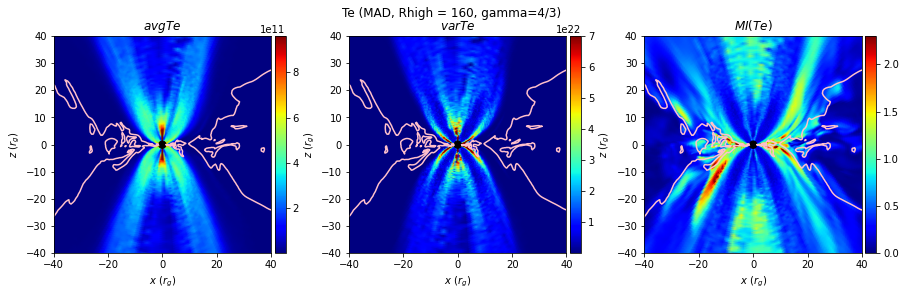

In [50]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dump0, 'avgTe', window=w, vmin=10**7, vmax=9.6*10**11)
pplt.plot_xz(axes[1], dump0, 'varTe', window=w, vmin=10**13, vmax=7.*10**22)
pplt.plot_xz(axes[2], dump0, 'MI(Te)', window=w, vmin=0., vmax=2.3)
pplt.overlay_contours(axes[0], dump0, 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dump0, 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dump0, 'beta',(1.0,), color='pink')
# 3 σ away, i.e. MI > 3
# pplt.overlay_contours(axes[2], dump0, 'MI(Te)',(3.0, ), color='white')
plt.suptitle('Te (MAD, Rhigh = 160, gamma=4/3)')
plt.show()

SANE, Pg, $\rho$, bsq

In [24]:
avg_Pg_sa = calculate_average(i0, i1, src_sa_5M, 'Pg')

In [25]:
var_Pg_sa = calculate_variance(i0, i1, src_sa_5M, 'Pg', avg_Pg_sa)

In [26]:
dump0_sa = pyharm.load_dump(fname(i0, src_sa_5M))

In [27]:
dump0_sa.cache['avgPg'] = avg_Pg_sa
dump0_sa.cache['varPg'] = var_Pg_sa

In [28]:
get_statistics(dump0_sa, 'avgPg')
print()
get_statistics(dump0_sa, 'varPg')

statistics on avgPg:
max avgPg:
2.376014e-02
percentile on avgPg [25%, 75%, 90%]:
[1.68360483e-07 5.95830374e-04 3.79086992e-03]

statistics on varPg:
max varPg:
1.477960e-04
percentile on varPg [25%, 75%, 90%]:
[5.54543700e-17 7.59772955e-09 5.33171925e-07]


In [29]:
MI(dump0_sa, 'Pg')
get_statistics(dump0_sa, 'MI(Pg)')

statistics on MI(Pg):
max MI(Pg):
5.113732e+00
percentile on MI(Pg) [25%, 75%, 90%]:
[0.03136342 0.25946837 0.67172932]


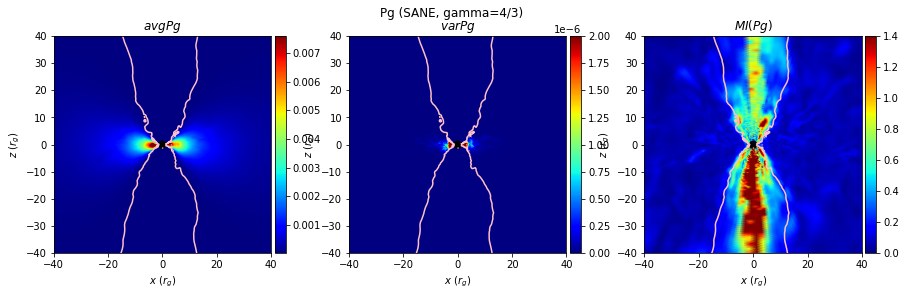

In [31]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dump0_sa, 'avgPg', window=w, vmin=10**(-7), vmax=7.6*10**(-3))
pplt.plot_xz(axes[1], dump0_sa, 'varPg', window=w, vmin=10**(-17), vmax=2.*10**(-6))
pplt.plot_xz(axes[2], dump0_sa, 'MI(Pg)', window=w, vmin=0., vmax=1.4)
pplt.overlay_contours(axes[0], dump0_sa, 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dump0_sa, 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dump0_sa, 'beta',(1.0,), color='pink')
# 3 σ away, i.e. MI > 3
# pplt.overlay_contours(axes[2], dump0_sa, 'MI(Pg)',(3.0, ), color='white')
plt.suptitle('Pg (SANE, gamma=4/3)')
plt.show()

In [32]:
avg_RHO_sa = calculate_average(i0, i1, src_sa_5M, 'RHO')

In [33]:
var_RHO_sa = calculate_variance(i0, i1, src_sa_5M, 'RHO', avg_RHO_sa)

In [34]:
dump0_sa.cache['avgRHO'] = avg_RHO_sa
dump0_sa.cache['varRHO'] = var_RHO_sa

In [35]:
get_statistics(dump0_sa, 'avgRHO')
print()
get_statistics(dump0_sa, 'varRHO')

statistics on avgRHO:
max avgRHO:
3.130494e-01
percentile on avgRHO [25%, 75%, 90%]:
[4.68511798e-05 6.05841237e-02 1.63353594e-01]

statistics on varRHO:
max varRHO:
1.934736e-02
percentile on varRHO [25%, 75%, 90%]:
[6.40322652e-12 5.23580997e-05 8.05402692e-04]


In [36]:
MI(dump0_sa, 'RHO')
get_statistics(dump0_sa, 'MI(RHO)')

statistics on MI(RHO):
max MI(RHO):
4.806399e+00
percentile on MI(RHO) [25%, 75%, 90%]:
[0.02591101 0.18341897 0.58168494]


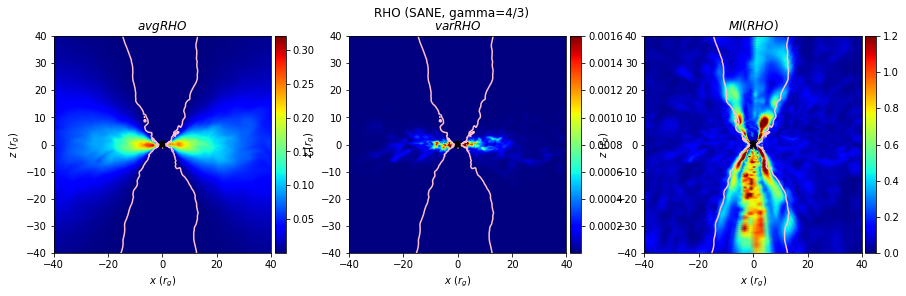

In [37]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dump0_sa, 'avgRHO', window=w, vmin=10**(-5), vmax=3.2*10**(-1))
pplt.plot_xz(axes[1], dump0_sa, 'varRHO', window=w, vmin=10**(-12), vmax=1.6*10**(-3))
pplt.plot_xz(axes[2], dump0_sa, 'MI(RHO)', window=w, vmin=0., vmax=1.2)
pplt.overlay_contours(axes[0], dump0_sa, 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dump0_sa, 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dump0_sa, 'beta',(1.0,), color='pink')
# 3 σ away, i.e. MI > 3
# pplt.overlay_contours(axes[2], dump0, 'MI(RHO)',(3.0, ), color='white')
plt.suptitle('RHO (SANE, gamma=4/3)')
plt.show()

In [38]:
avg_bsq_sa = calculate_average(i0, i1, src_sa_5M, 'bsq')

In [39]:
var_bsq_sa = calculate_variance(i0, i1, src_sa_5M, 'bsq', avg_bsq_sa)

In [40]:
dump0_sa.cache['avgbsq'] = avg_bsq_sa
dump0_sa.cache['varbsq'] = var_bsq_sa

In [41]:
get_statistics(dump0_sa, 'avgbsq')
print()
get_statistics(dump0_sa, 'varbsq')

statistics on avgbsq:
max avgbsq:
7.540685e-02
percentile on avgbsq [25%, 75%, 90%]:
[2.52364126e-08 3.75500511e-04 3.14042188e-03]

statistics on varbsq:
max varbsq:
4.428741e-04
percentile on varbsq [25%, 75%, 90%]:
[8.65992338e-18 4.82110195e-08 1.32228175e-06]


In [42]:
MI(dump0_sa, 'bsq')
get_statistics(dump0_sa, 'MI(bsq)')

statistics on MI(bsq):
max MI(bsq):
3.258944e+00
percentile on MI(bsq) [25%, 75%, 90%]:
[0.07049713 0.97573193 1.28868194]


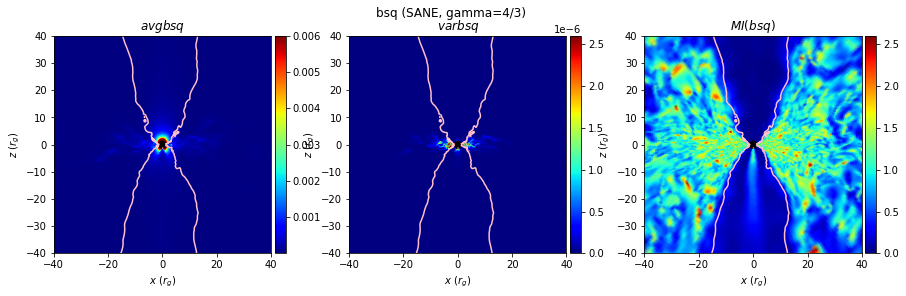

In [43]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dump0_sa, 'avgbsq', window=w, vmin=10**(-8), vmax=6*10**(-3))
pplt.plot_xz(axes[1], dump0_sa, 'varbsq', window=w, vmin=10**(-18), vmax=2.6*10**(-6))
pplt.plot_xz(axes[2], dump0_sa, 'MI(bsq)', window=w, vmin=0., vmax=2.6)
pplt.overlay_contours(axes[0], dump0_sa, 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dump0_sa, 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dump0_sa, 'beta',(1.0,), color='pink')
# 3 σ away, i.e. MI > 3
# pplt.overlay_contours(axes[2], dump0, 'MI(bsq)',(3.0, ), color='white')
plt.suptitle('bsq (SANE, gamma=4/3)')
plt.show()

SANE model, $R_{high}$ = 1

In [51]:
avg_Te_sa = calculate_avgTe(i0, i1, src_sa_5M, 1.)

In [52]:
var_Te_sa = calculate_varTe(i0, i1, src_sa_5M, 1., avg_Te_sa)

In [53]:
dump0_sa = pyharm.load_dump(fname(i0, src_sa_5M))

In [54]:
dump0_sa.cache['avgTe'] = avg_Te_sa
dump0_sa.cache['varTe'] = var_Te_sa

In [55]:
get_statistics(dump0_sa, 'avgTe')
print()
get_statistics(dump0_sa, 'varTe')

statistics on avgTe:
max avgTe:
1.106060e+12
percentile on avgTe [25%, 75%, 90%]:
[3.44066305e+09 8.03298082e+10 1.56672642e+11]

statistics on varTe:
max varTe:
2.158594e+23
percentile on varTe [25%, 75%, 90%]:
[1.90335684e+15 9.20549590e+19 3.43363507e+21]


In [56]:
MI(dump0_sa, 'Te')
get_statistics(dump0_sa, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
1.946759e+00
percentile on MI(Te) [25%, 75%, 90%]:
[0.01314514 0.11842799 0.39123666]


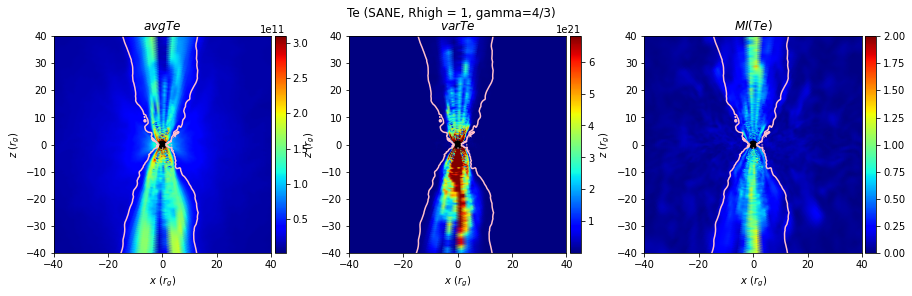

In [57]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dump0_sa, 'avgTe', window=w, vmin=10**9, vmax=3.1*10**11)
pplt.plot_xz(axes[1], dump0_sa, 'varTe', window=w, vmin=10**15, vmax=6.8*10**21)
pplt.plot_xz(axes[2], dump0_sa, 'MI(Te)', window=w, vmin=0., vmax=2.)
pplt.overlay_contours(axes[0], dump0_sa, 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dump0_sa, 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dump0_sa, 'beta',(1.0,), color='pink')
# 3 σ away, i.e. MI > 3
#pplt.overlay_contours(axes[2], dump0_sa, 'MI(Te)',(3.0, ), color='white')
plt.suptitle('Te (SANE, Rhigh = 1, gamma=4/3)')
plt.show()

SANE, $r_{h}=160$

In [58]:
avg_Te_sa_rh160 = calculate_avgTe(i0, i1, src_sa_5M, 160.)

In [59]:
var_Te_sa_rh160 = calculate_varTe(i0, i1, src_sa_5M, 160., avg_Te_sa_rh160)

In [60]:
dump0_sa = pyharm.load_dump(fname(i0, src_sa_5M))

In [61]:
dump0_sa.cache['avgTe'] = avg_Te_sa_rh160
dump0_sa.cache['varTe'] = var_Te_sa_rh160

In [62]:
get_statistics(dump0_sa, 'avgTe')
print()
get_statistics(dump0_sa, 'varTe')

statistics on avgTe:
max avgTe:
9.766633e+11
percentile on avgTe [25%, 75%, 90%]:
[2.43810804e+07 1.01151416e+09 1.04294193e+11]

statistics on varTe:
max varTe:
1.170283e+23
percentile on varTe [25%, 75%, 90%]:
[1.02906513e+11 7.87886020e+16 2.97923864e+21]


In [63]:
MI(dump0_sa, 'Te')
get_statistics(dump0_sa, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
4.881720e+00
percentile on MI(Te) [25%, 75%, 90%]:
[0.01395004 0.18209403 0.71207403]


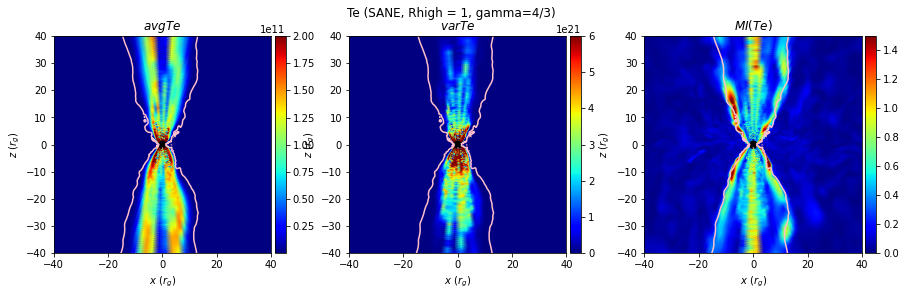

In [64]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dump0_sa, 'avgTe', window=w, vmin=10**7, vmax=2.*10**11)
pplt.plot_xz(axes[1], dump0_sa, 'varTe', window=w, vmin=10**11, vmax=6.*10**21)
pplt.plot_xz(axes[2], dump0_sa, 'MI(Te)', window=w, vmin=0., vmax=1.5)
pplt.overlay_contours(axes[0], dump0_sa, 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dump0_sa, 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dump0_sa, 'beta',(1.0,), color='pink')
# 3 σ away, i.e. MI > 3
# pplt.overlay_contours(axes[2], dump0_sa, 'MI(Te)',(3.0, ), color='white')
plt.suptitle('Te (SANE, Rhigh = 1, gamma=4/3)')
plt.show()

MAD model, $R_{high} = 10$

In [15]:
# MAD, R_h = 10
dumps_rh10 = change_Rh(i0, i1, src_ma_10M, 1)

finish reading in dumps
finish average calculation.
finish variance & standard deviation calculation's loop.


In [16]:
dumps_rh10_std = np.sqrt(dumps_rh10[str(i0)].cache['varTe'])
for dump in dumps_rh10.values():
    dump.cache['stdTe'] = dumps_rh10_std

In [17]:
print('statistics on avgTe:')
print('max avgTe:')
maximum = np.max(dumps_rh10[str(i0)].cache['avgTe'])
print("{:e}".format(maximum))
print('percentile on avgTe [25%, 50%, 75%]:')
# percentile of the flattened grid
percentile = np.percentile(dumps_rh10[str(i0)].cache['avgTe'], [25, 50, 75])
print(percentile)

statistics on avgTe:
max avgTe:
3.957489e+12
percentile on avgTe [25%, 50%, 75%]:
[1.14038996e+09 1.25498601e+10 2.48902321e+11]


In [19]:
get_statistics(dumps_rh10, 'stdTe')

statistics on stdTe:
max stdTe:
1.322973e+13
percentile on stdTe [50%, 75%, 90%]:
[3.37944694e+10 6.89390042e+11 1.35513303e+12]


In [20]:
MI(dumps_rh10, i0)

In [22]:
get_statistics(dumps_rh10, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
2.421502e+01
percentile on MI(Te) [50%, 75%, 90%]:
[1.52089022 3.65810462 5.66166166]


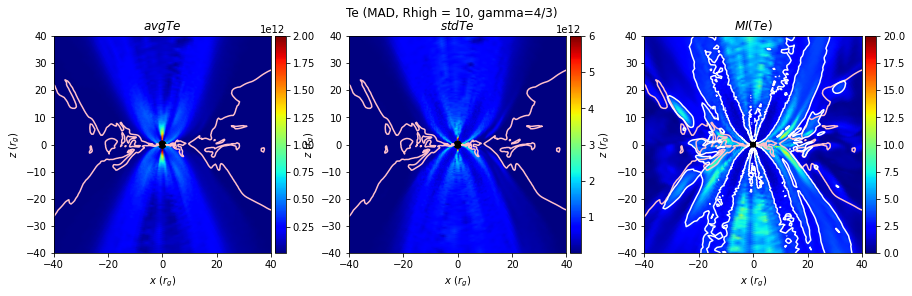

In [24]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_rh10[str(i0)], 'avgTe', window=w, vmin=5e9, vmax=2*10**12)
pplt.plot_xz(axes[1], dumps_rh10[str(i0)], 'stdTe', window=w, vmin=4e9, vmax=6.*10**12)
pplt.plot_xz(axes[2], dumps_rh10[str(i0)], 'MI(Te)', window=w, vmin=0., vmax=20)
pplt.overlay_contours(axes[0], dumps_rh10[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh10[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_rh10[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_rh10[str(i0)], 'MI(Te)',(3.0,), color='white')
plt.suptitle('Te (MAD, Rhigh = 10, gamma=4/3)')
plt.show()

SANE model, $R_{high} = 10$

In [15]:
# SANE, R_h = 10 (idx=1)
dumps_sa_rh10 = change_Rh(i0, i1, src_sa_10M, 1)

finish reading in dumps
finish average calculation.
finish variance & standard deviation calculation's loop.


In [16]:
dumps_sa_rh10_std = np.sqrt(dumps_sa_rh10[str(i0)].cache['varTe'])
for dump in dumps_sa_rh10.values():
    dump.cache['stdTe'] = dumps_sa_rh10_std

In [17]:
get_statistics(dumps_sa_rh10, 'avgTe')
print()
get_statistics(dumps_sa_rh10, 'varTe')
print()
get_statistics(dumps_sa_rh10, 'stdTe')

statistics on avgTe:
max avgTe:
1.084082e+12
percentile on avgTe [50%, 75%, 90%]:
[2.39669880e+09 1.39331286e+10 1.22006933e+11]

statistics on varTe:
max varTe:
1.073672e+25
percentile on varTe [50%, 75%, 90%]:
[9.99687374e+17 3.23326738e+20 1.77739527e+23]

statistics on stdTe:
max stdTe:
3.276694e+12
percentile on stdTe [50%, 75%, 90%]:
[9.99843675e+08 1.79812886e+10 4.21591659e+11]


In [18]:
MI(dumps_sa_rh10, i0)

In [20]:
get_statistics(dumps_sa_rh10, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
2.212697e+01
percentile on MI(Te) [50%, 75%, 90%]:
[0.40677423 1.18194208 3.94294619]


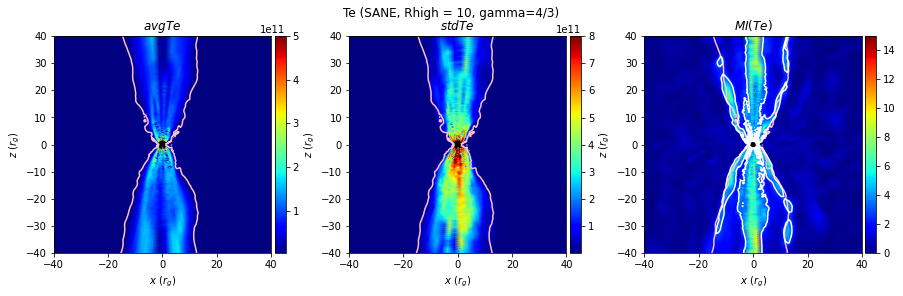

In [21]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh10[str(i0)], 'avgTe', window=w, vmin=2e9, vmax=5.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh10[str(i0)], 'stdTe', window=w, vmin=5e8, vmax=8e11)
pplt.plot_xz(axes[2], dumps_sa_rh10[str(i0)], 'MI(Te)', window=w, vmin=0, vmax=15)
pplt.overlay_contours(axes[0], dumps_sa_rh10[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh10[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa_rh10[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa_rh10[str(i0)], 'MI(Te)',(3.0,), color='white')
plt.suptitle('Te (SANE, Rhigh = 10, gamma=4/3)')
plt.show()

MAD model, $R_{high} = 40$

In [15]:
# MAD, R_h = 40
dumps_rh40 = change_Rh(i0, i1, src_ma_10M, 2)

finish reading in dumps
finish average calculation.
finish variance & standard deviation calculation's loop.


In [17]:
dumps_rh40_std = np.sqrt(dumps_rh40[str(i0)].cache['varTe'])
for dump in dumps_rh40.values():
    dump.cache['stdTe'] = dumps_rh40_std

In [18]:
get_statistics(dumps_rh40, 'avgTe')
print()
get_statistics(dumps_rh40, 'stdTe')

statistics on avgTe:
max avgTe:
3.832159e+12
percentile on avgTe [50%, 75%, 90%]:
[4.96572526e+09 2.36068062e+11 4.88379567e+11]

statistics on stdTe:
max stdTe:
1.067272e+13
percentile on stdTe [50%, 75%, 90%]:
[1.84976526e+10 6.76571304e+11 1.35660843e+12]


In [19]:
MI(dumps_rh40, i0)
get_statistics(dumps_rh40, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
3.307747e+01
percentile on MI(Te) [50%, 75%, 90%]:
[1.61390877 4.17117741 7.06498111]


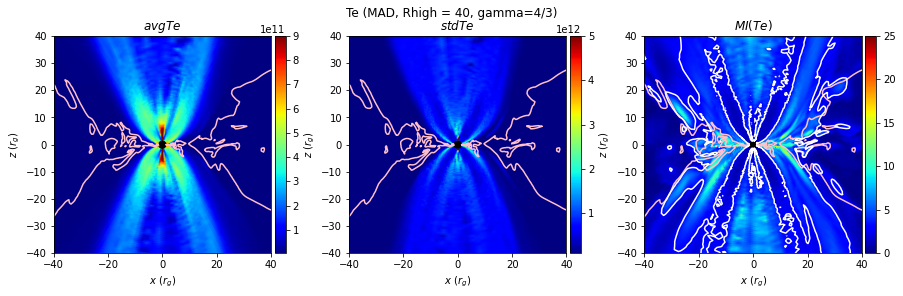

In [22]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_rh40[str(i0)], 'avgTe', window=w, vmin=2.5e9, vmax=9*10**11)
pplt.plot_xz(axes[1], dumps_rh40[str(i0)], 'stdTe', window=w, vmin=9e10, vmax=5.*10**12)
pplt.plot_xz(axes[2], dumps_rh40[str(i0)], 'MI(Te)', window=w, vmin=0, vmax=25)

pplt.overlay_contours(axes[0], dumps_rh40[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh40[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_rh40[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_rh40[str(i0)], 'MI(Te)', (3.0,), color='white')
plt.suptitle('Te (MAD, Rhigh = 40, gamma=4/3)')
plt.show()

SANE, $R_{high}=40$

In [15]:
# SANE, R_h = 40 (idx=2)
dumps_sa_rh40 = change_Rh(i0, i1, src_sa_10M, 2)

finish reading in dumps
finish average calculation.
finish variance & standard deviation calculation's loop.


In [17]:
dumps_sa_rh40_std = np.sqrt(dumps_sa_rh40[str(i0)].cache['varTe'])
for dump in dumps_sa_rh40.values():
    dump.cache['stdTe'] = dumps_sa_rh40_std

In [18]:
get_statistics(dumps_sa_rh40, 'avgTe')
print()
get_statistics(dumps_sa_rh40, 'stdTe')

statistics on avgTe:
max avgTe:
1.030431e+12
percentile on avgTe [50%, 75%, 90%]:
[6.06836378e+08 3.95886572e+09 1.14748760e+11]

statistics on stdTe:
max stdTe:
2.967901e+12
percentile on stdTe [50%, 75%, 90%]:
[2.55657653e+08 7.01202845e+09 4.14100759e+11]


In [19]:
MI(dumps_sa_rh40, i0)

In [20]:
get_statistics(dumps_sa_rh40, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
3.281676e+01
percentile on MI(Te) [50%, 75%, 90%]:
[0.41536055 1.33712824 4.71887029]


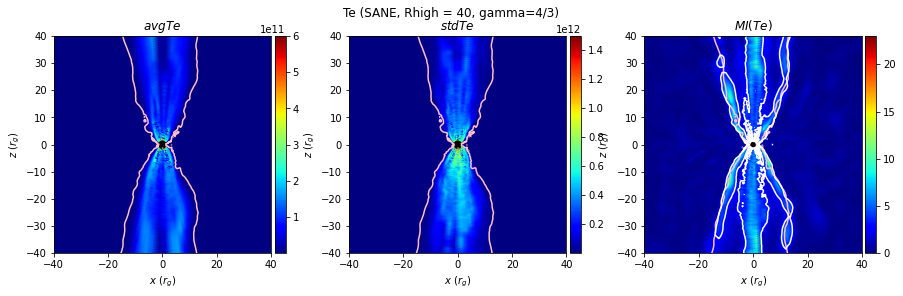

In [22]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh40[str(i0)], 'avgTe', window=w, vmin=3*10**8, vmax=6.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh40[str(i0)], 'stdTe', window=w, vmin=10**8, vmax=1.5*10**12)
pplt.plot_xz(axes[2], dumps_sa_rh40[str(i0)], 'MI(Te)', window=w, vmin=0, vmax=23)

pplt.overlay_contours(axes[0], dumps_sa_rh40[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh40[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa_rh40[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa_rh40[str(i0)], 'MI(Te)', (3.0,), color='white')
plt.suptitle('Te (SANE, Rhigh = 40, gamma=4/3)')
plt.show()

MAD, $R_{high}=160$

In [15]:
# MAD, R_h = 160
dumps_rh160 = change_Rh(i0, i1, src_ma_10M, 3)

finish reading in dumps
finish average calculation.
finish variance & standard deviation calculation's loop.


In [16]:
for dump in dumps_rh160.values():
    # if type(dump) is not str:
    dump.cache['stdTe'] = np.squeeze(np.array(list(np.sqrt(dump.cache['varTe']))))

In [17]:
get_statistics(dumps_rh160, 'avgTe')
print()
get_statistics(dumps_rh160, 'stdTe')

statistics on avgTe:
max avgTe:
3.417263e+12
percentile on avgTe [50%, 75%, 90%]:
[1.51986525e+09 2.22584648e+11 4.78441947e+11]

statistics on stdTe:
max stdTe:
9.084893e+12
percentile on stdTe [50%, 75%, 90%]:
[6.62378630e+09 6.58655978e+11 1.34419897e+12]


In [18]:
MI(dumps_rh160, i0)

In [19]:
get_statistics(dumps_rh160, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
3.930615e+01
percentile on MI(Te) [50%, 75%, 90%]:
[1.65745659 4.54388984 8.52754387]


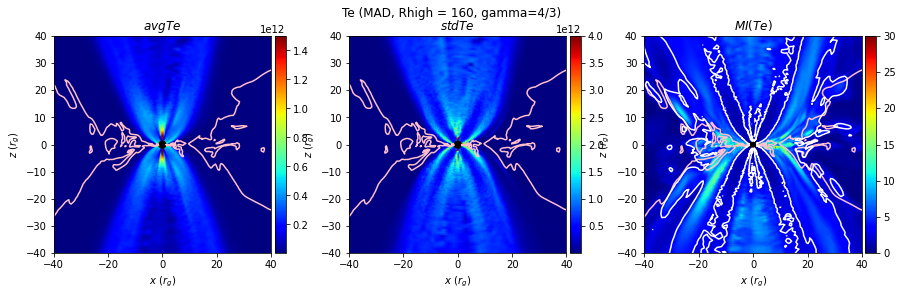

In [21]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_rh160[str(i0)], 'avgTe', window=w, vmin=7*10**8, vmax=1.5*10**12)
pplt.plot_xz(axes[1], dumps_rh160[str(i0)], 'stdTe', window=w, vmin=3e9, vmax=4e12)
pplt.plot_xz(axes[2], dumps_rh160[str(i0)], 'MI(Te)', window=w, vmin=0., vmax=30)

pplt.overlay_contours(axes[0], dumps_rh160[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_rh160[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_rh160[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_rh160[str(i0)], 'MI(Te)',(3.0,), color='white')
plt.suptitle('Te (MAD, Rhigh = 160, gamma=4/3)')
plt.show()

SANE, $R_{high}$=160

In [15]:
# SANE, R_h = 160 (idx=3)
dumps_sa_rh160 = change_Rh(i0, i1, src_sa_10M, 3)

finish reading in dumps
finish average calculation.
finish variance & standard deviation calculation's loop.


In [16]:
for dump in dumps_sa_rh160.values():
    # if type(dump) is not str:
    dump.cache['stdTe'] = np.squeeze(np.array(list(np.sqrt(dump.cache['varTe']))))

In [17]:
get_statistics(dumps_sa_rh160, 'avgTe')
print()
get_statistics(dumps_sa_rh160, 'stdTe')

statistics on avgTe:
max avgTe:
9.805490e+11
percentile on avgTe [50%, 75%, 90%]:
[1.52223932e+08 1.01558993e+09 1.03078203e+11]

statistics on stdTe:
max stdTe:
2.445387e+12
percentile on stdTe [50%, 75%, 90%]:
[6.43064708e+07 2.26217284e+09 3.95132489e+11]


In [18]:
MI(dumps_sa_rh160, i0)

In [19]:
get_statistics(dumps_sa_rh160, 'MI(Te)')

statistics on MI(Te):
max MI(Te):
3.736543e+01
percentile on MI(Te) [50%, 75%, 90%]:
[0.42208697 1.4181353  5.25534003]


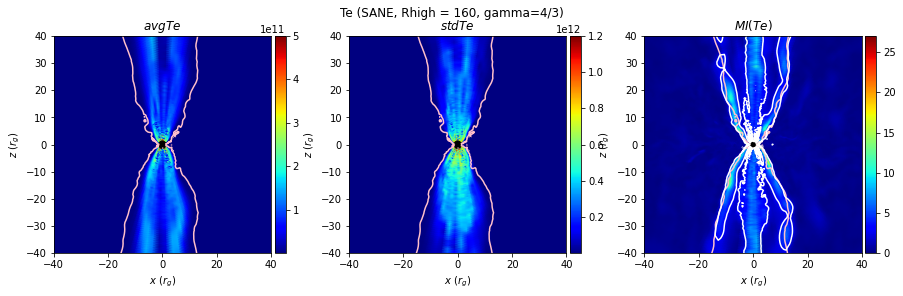

In [21]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps array will give the same average value (avg for these dumps)
# dumps[str(i0)].cache.values = list(dumps[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa_rh160[str(i0)], 'avgTe', window=w, vmin=7.5e7, vmax=5.*10**11)
pplt.plot_xz(axes[1], dumps_sa_rh160[str(i0)], 'stdTe', window=w, vmin=3.2e7, vmax=1.2e12)
pplt.plot_xz(axes[2], dumps_sa_rh160[str(i0)], 'MI(Te)', window=w, vmin=0., vmax=27)

pplt.overlay_contours(axes[0], dumps_sa_rh160[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa_rh160[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa_rh160[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa_rh160[str(i0)], 'MI(Te)',(3.0,), color='white')
plt.suptitle('Te (SANE, Rhigh = 160, gamma=4/3)')
plt.show()

### $\beta$ -MAD

In [18]:
for dump in dumps_ma.values():
    dump['beta']

In [19]:
# avg
beta_ma_avg = average(range(i0, i1), dumps_ma,  ['beta'])
for dump in dumps_ma.values():
    dump.cache['avgbeta'] = np.squeeze(np.array(list(beta_ma_avg.values())))

finish average calculation.


In [20]:
# variance & standard deviation
variance(range(i0, i1), dumps_ma, 'beta')

beta_ma_std = np.sqrt(dumps_ma[str(i0)].cache['varbeta'])
for dump in dumps_ma.values():
    dump.cache['stdbeta'] = beta_ma_std

finish variance & standard deviation calculation's loop.


In [21]:
# log beta
beta_ma_log = np.log10(dumps_ma[str(i0)].cache['beta'])
for dump in dumps_ma.values():
    dump.cache['log(beta)'] = beta_ma_log

In [22]:
# log avg
beta_ma_avglog = average(range(i0, i1), dumps_ma, ['log(beta)'])
for dump in dumps_ma.values():
    dump.cache['avglog(beta)'] = np.squeeze(np.array(list(beta_ma_avglog.values())))

finish average calculation.


In [23]:
# log variance & standard deviation
variance(range(i0, i1), dumps_ma, 'log(beta)')

beta_ma_stdlog = np.sqrt(dumps_ma[str(i0)].cache['varlog(beta)'])
for dump in dumps_ma.values():
    dump.cache['std(log(beta))'] = beta_ma_stdlog

finish variance & standard deviation calculation's loop.


In [20]:
get_statistics(dumps_ma, 'avgbeta')
print()
get_statistics(dumps_ma, 'varbeta')
print()
get_statistics(dumps_ma, 'stdbeta')

statistics on avgbeta:
max avgbeta:
1.791540e+06
percentile on avgbeta [50%, 75%, 90%]:
[  1.58619683  14.81911525 103.59650735]

statistics on varbeta:
max varbeta:
3.303206e+14
percentile on varbeta [50%, 75%, 90%]:
[1.08444134e+01 5.22684160e+03 1.57427999e+05]

statistics on stdbeta:
max stdbeta:
1.817472e+07
percentile on stdbeta [50%, 75%, 90%]:
[  3.29308569  72.29689897 396.77197305]


In [24]:
# MI
MI(dumps_ma, i0, 'beta')
get_statistics(dumps_ma, 'MI(beta)')

statistics on MI(beta):
max MI(beta):
5.049480e+01
percentile on MI(beta) [50%, 75%, 90%]:
[ 3.55110679 10.28843237 20.45656093]


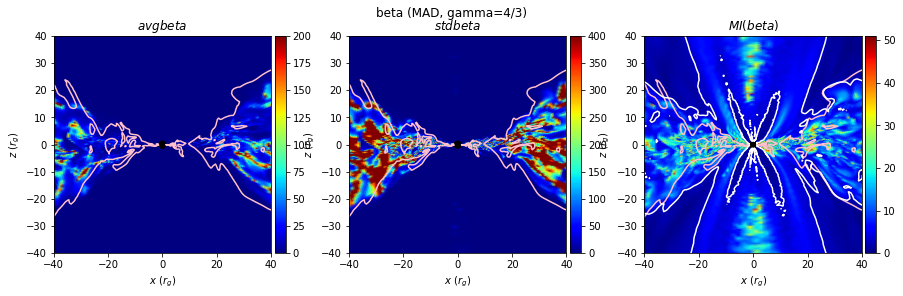

In [67]:
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_ma array will give the same average value (avg for these dumps_ma)
# dumps_ma[str(i0)].cache.values = list(dumps_ma[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_ma[str(i0)], 'avgbeta', window=w, vmin=0., vmax=2e2)
pplt.plot_xz(axes[1], dumps_ma[str(i0)], 'stdbeta', window=w, vmin=0., vmax=4e2)
pplt.plot_xz(axes[2], dumps_ma[str(i0)], 'MI(beta)', window=w, vmin=0., vmax=51)
pplt.overlay_contours(axes[0], dumps_ma[str(i0)], 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_ma[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_ma[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_ma[str(i0)], 'MI(beta)',(3.0, ), color='white')
plt.suptitle('beta (MAD, gamma=4/3)')
plt.show()

In [24]:
get_statistics(dumps_ma, 'avglog(beta)')
print()
get_statistics(dumps_ma, 'std(log(beta))')

statistics on avglog(beta):
max avglog(beta):
6.217394e+00
percentile on avglog(beta) [50%, 75%, 90%]:
[-0.13875137  1.00459396  1.94320687]

statistics on std(log(beta)):
max std(log(beta)):
5.708576e-14
percentile on std(log(beta)) [50%, 75%, 90%]:
[3.96428914e-15 9.51429392e-15 1.58571565e-14]


In [25]:
MI(dumps_ma, i0, 'beta')
dumps_ma[str(i0)].cache['log(MI(beta))'] = np.log10(dumps_ma[str(i0)].cache['MI(beta)'])
get_statistics(dumps_ma, 'log(MI(beta))')

statistics on log(MI(beta)):
max log(MI(beta)):
1.703247e+00
percentile on log(MI(beta)) [50%, 75%, 90%]:
[0.55036373 1.01234921 1.31083262]


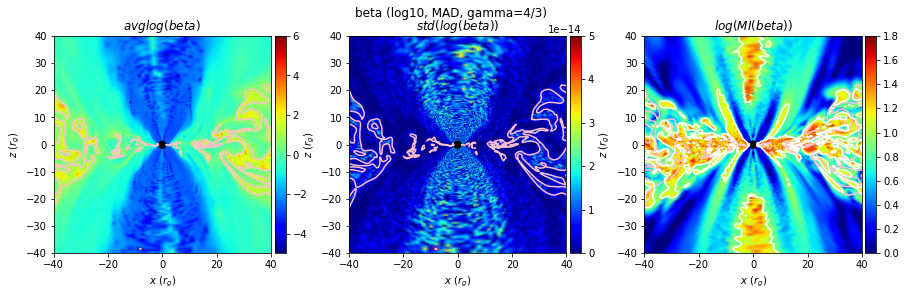

In [34]:
# logscale
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_sa array will give the same average value (avg for these dumps_sa)
# dumps_sa[str(i0)].cache.values = list(dumps_sa[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_ma[str(i0)], 'avglog(beta)', window=w, vmin=-5., vmax=6.)
pplt.plot_xz(axes[1], dumps_ma[str(i0)], 'std(log(beta))', window=w, vmin=0., vmax=5e-14)
pplt.plot_xz(axes[2], dumps_ma[str(i0)], 'log(MI(beta))', window=w, vmin=0., vmax=1.8)
pplt.overlay_contours(axes[0], dumps_ma[str(i0)], 'log(beta)', (-5, 1.0), color='pink')
pplt.overlay_contours(axes[1], dumps_ma[str(i0)], 'log(beta)',(-5, 1.0), color='pink')
pplt.overlay_contours(axes[2], dumps_ma[str(i0)], 'log(beta)',(-5, 1.0), color='pink')
pplt.overlay_contours(axes[2], dumps_ma[str(i0)], 'log(MI(beta))',(-5, 1.0), color='white')
plt.suptitle('beta (log10, MAD, gamma=4/3)')
plt.show()

### $\beta$ -SANE

In [16]:
for dump in dumps_sa.values():
    dump['beta']

In [18]:
# avg
beta_sa_avg = average(range(i0, i1), dumps_sa, ['beta'])
for dump in dumps_sa.values():
    dump.cache['avgbeta'] = np.squeeze(np.array(list(beta_sa_avg.values())))

finish average calculation.


In [19]:
# variance & standard deviation
variance(range(i0, i1), dumps_sa, 'beta')

beta_sa_std = np.sqrt(dumps_sa[str(i0)].cache['varbeta'])
for dump in dumps_sa.values():
    dump.cache['stdbeta'] = beta_sa_std

finish variance & standard deviation calculation's loop.


In [20]:
# log beta
beta_sa_log = np.log10(dumps_sa[str(i0)].cache['beta'])
for dump in dumps_sa.values():
    dump.cache['log(beta)'] = beta_sa_log

In [21]:
# log avg
beta_sa_avglog = average(range(i0, i1), dumps_sa, ['log(beta)'])
for dump in dumps_sa.values():
    dump.cache['avglog(beta)'] = np.squeeze(np.array(list(beta_sa_avglog.values())))

finish average calculation.


In [22]:
# log variance & standard deviation
variance(range(i0, i1), dumps_sa, 'log(beta)')

beta_sa_stdlog = np.sqrt(dumps_sa[str(i0)].cache['varlog(beta)'])
for dump in dumps_sa.values():
    dump.cache['std(log(beta))'] = beta_sa_stdlog

finish variance & standard deviation calculation's loop.


In [20]:
get_statistics(dumps_sa, 'avgbeta')
print()
get_statistics(dumps_sa, 'varbeta')
print()
get_statistics(dumps_sa, 'stdbeta')

statistics on avgbeta:
max avgbeta:
5.021887e+06
percentile on avgbeta [50%, 75%, 90%]:
[ 42.90227864 218.2695992  541.14368243]

statistics on varbeta:
max varbeta:
6.418597e+16
percentile on varbeta [50%, 75%, 90%]:
[1.72752643e+04 6.69443316e+06 6.27712976e+07]

statistics on stdbeta:
max stdbeta:
2.533495e+08
percentile on stdbeta [50%, 75%, 90%]:
[ 131.43539958 2587.36026907 7922.8339382 ]


In [21]:
# MI
MI(dumps_sa, i0, 'beta')
get_statistics(dumps_sa, 'MI(beta)')

statistics on MI(beta):
max MI(beta):
5.049029e+01
percentile on MI(beta) [50%, 75%, 90%]:
[ 6.06851162 14.56015332 21.96000592]


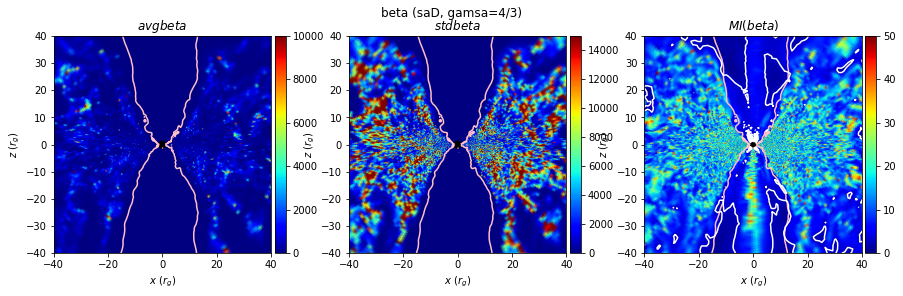

In [32]:
# normal scale
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_sa array will give the same average value (avg for these dumps_sa)
# dumps_sa[str(i0)].cache.values = list(dumps_sa[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa[str(i0)], 'avgbeta', window=w, vmin=0., vmax=1e4)
pplt.plot_xz(axes[1], dumps_sa[str(i0)], 'stdbeta', window=w, vmin=0., vmax=1.5e4)
pplt.plot_xz(axes[2], dumps_sa[str(i0)], 'MI(beta)', window=w, vmin=0., vmax=50)
pplt.overlay_contours(axes[0], dumps_sa[str(i0)], 'beta', (1.0,), color='pink')
pplt.overlay_contours(axes[1], dumps_sa[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa[str(i0)], 'beta',(1.0,), color='pink')
pplt.overlay_contours(axes[2], dumps_sa[str(i0)], 'MI(beta)',(3.0, ), color='white')
plt.suptitle('beta (SANE, gamma=4/3)')
plt.show()

In [30]:
get_statistics(dumps_sa, 'avglog(beta)')
print()
get_statistics(dumps_sa, 'std(log(beta))')

statistics on avglog(beta):
max avglog(beta):
7.289414e+00
percentile on avglog(beta) [25%, 75%, 90%]:
[0.16060972 1.93660259 2.55849616]

statistics on std(log(beta)):
max std(log(beta)):
6.342863e-14
percentile on std(log(beta)) [25%, 75%, 90%]:
[1.58571565e-15 9.51429392e-15 1.58571565e-14]


In [31]:
MI(dumps_sa, i0, 'beta')
dumps_sa[str(i0)].cache['log(MI(beta))'] = np.log10(dumps_sa[str(i0)].cache['MI(beta)'])
get_statistics(dumps_sa, 'log(MI(beta))')

statistics on log(MI(beta)):
max log(MI(beta)):
1.703208e+00
percentile on log(MI(beta)) [25%, 75%, 90%]:
[0.08284429 1.16316595 1.34163245]


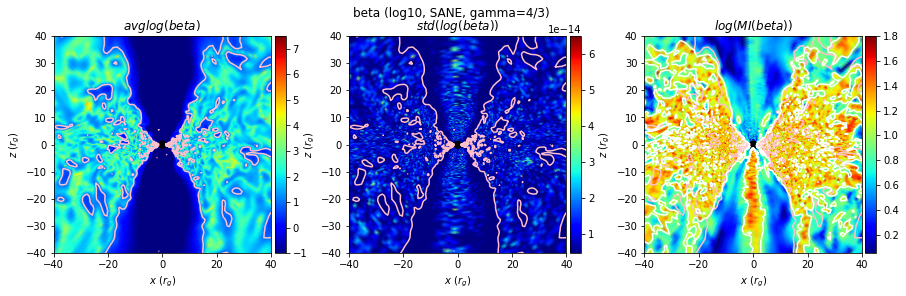

In [32]:
# logscale
w = (-40,40,-40,40)
fig, axes = plt.subplots(1,3, figsize=(15,4))
# any dump obj in dumps_sa array will give the same average value (avg for these dumps_sa)
# dumps_sa[str(i0)].cache.values = list(dumps_sa[str(i0)].cache.values())[0]
pplt.plot_xz(axes[0], dumps_sa[str(i0)], 'avglog(beta)', window=w, vmin=-1., vmax=7.5)
pplt.plot_xz(axes[1], dumps_sa[str(i0)], 'std(log(beta))', window=w, vmin=4.7e-15, vmax=6.5e-14)
pplt.plot_xz(axes[2], dumps_sa[str(i0)], 'log(MI(beta))', window=w, vmin=0.05, vmax=1.8)
pplt.overlay_contours(axes[0], dumps_sa[str(i0)], 'log(beta)', (-5, 1.), color='pink')
pplt.overlay_contours(axes[1], dumps_sa[str(i0)], 'log(beta)',(-5, 1.0), color='pink')
pplt.overlay_contours(axes[2], dumps_sa[str(i0)], 'log(beta)',(-5, 1.0), color='pink')
pplt.overlay_contours(axes[2], dumps_sa[str(i0)], 'log(MI(beta))',(-5, 1.), color='white')
plt.suptitle('beta (log10, SANE, gamma=4/3)')
plt.show()